# 导入模块

In [2]:
import pandas as pd
from datetime import datetime
import rqalpha as rqa
import rqalpha_plus
import rqdatac as rqd
import rqoptimizer as rqo
from rqoptimizer.utils import stock_select,TotalStockCountTarget

rqd.init()

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


# 回测

In [9]:
_ALPHA_SCORE_CACHE = None


def get_alpha_score(date, path=None):
    """从本地文件读取指定日期的alpha分数"""
    # 以一个全局变量作为缓存, 一次性将所有数据读入, 减少文件IO
    global _ALPHA_SCORE_CACHE
    if _ALPHA_SCORE_CACHE is None:
        _ALPHA_SCORE_CACHE = pd.read_csv(path, header=None)
        _ALPHA_SCORE_CACHE[0] = _ALPHA_SCORE_CACHE[0].astype(str)
        _ALPHA_SCORE_CACHE.columns = ['date', 'code', 'factor']
        _ALPHA_SCORE_CACHE['code'] = _ALPHA_SCORE_CACHE['code'].map(
            lambda x: x.replace('SZ', 'XSHE') if x[-2:] == 'SZ' else x.replace('SH', 'XSHG'))
        _ALPHA_SCORE_CACHE.set_index(['date', 'code'], inplace=True)
    if date in _ALPHA_SCORE_CACHE.index.levels[0]:
        return _ALPHA_SCORE_CACHE.loc[date].squeeze()
    return None


def init(context):
    pass


def _should_rebalance(context):
    """判断当日是否需要调仓"""
    today = context.now.strftime('%Y%m%d')
    score = get_alpha_score(today, context.alpha_score_path)
    # 若当日的读取的alpha分数非空, 则执行调仓
    return score


def handle_bar_500_enhanced(context, bar_dict):
    if _should_rebalance(context) is None:
        return
    today = context.now.strftime('%Y%m%d')
     # 目标股和分数
    target_stock,score = get_500_enhanced_universe(today,context.stock_num)
    # 目标权重
    target_portfolio = get_500_enhanced_portfolio(target_stock,today,score,context.benchmark)
    # 调仓函数
    rebalance(context,bar_dict,target_portfolio)


def get_500_enhanced_universe(date,stock_num):
    score = get_alpha_score(date)
    # 优先级都相同,设为0
    pool = pd.Series(0,index=score.index)
    targets = [TotalStockCountTarget(stock_num)]
    target_stock = stock_select(pool, targets, date, score, benchmark=None)
    return target_stock, score


def get_500_enhanced_portfolio(target_stock,date,score,benchmark):
    
    # define objective and constrains according to specification
    objective = rqo.MaxIndicator(score)
    
    # industry constraints
    industry_constraints_1 = rqo.IndustryConstraint(
                                ['医药','电子','通信','计算机'],
                                lower_limit=-0.02,
                                upper_limit=0,
                                relative=True,
                                hard=False,
                                classification=rqo.IndustryClassification.ZX)
    industry_constraints_2 = rqo.IndustryConstraint(
                                ['传媒', '消费者服务'],
                                lower_limit=0,
                                upper_limit=0.02,
                                relative=True,
                                hard=False,
                                classification=rqo.IndustryClassification.ZX)
    # 其余行业约束
    industry_constraints_else = rqo.WildcardIndustryConstraint(
                                exclude=['医药','电子','通信','计算机', '传媒', '消费者服务'],
                                lower_limit=-0.03,
                                upper_limit=0.03,
                                relative=True,
                                hard=False,
                                classification=rqo.IndustryClassification.ZX)
    # style constraints
    style_constraints = rqo.StyleConstraint(
                                ['earnings_yield','size'],lower_limit=0,upper_limit=0.5,relative=True,hard=False)
    
#     # trackingerror constraints
#     trackingerro_constraints = rqo.TrackingErrorLimit(upper_limit=0.05, hard=False)
#     # turnover constraints
#     current_holding = context.positions 
#     turnover_contraints = rqo.TurnoverLimit(current_holding, ...)
    
    constraints = [industry_constraints_1,industry_constraints_2,industry_constraints_else, style_constraints]
    # weight of single stock constraints
    bnds = {'*':(0,0.04)}
    target_portfolio = rqo.portfolio_optimize(target_stock,date, 
                                       benchmark=benchmark, 
                                       objective=objective,
                                       cons=constraints,
                                       bnds=bnds) 
    
    return target_portfolio.loc[lambda x:x!=0]


def rebalance(context, bar_dict, target_portfolio):

    positions = context.stock_account.positions
    for order_book_id in positions:
        if order_book_id not in target_portfolio:
            rqa.api.order_to(order_book_id, 0)

    # 对每个股票计算目标价值和当前价值的差值
    # 差值为正的是买单, 反之为卖单
    capital = context.stock_account.total_value * (1 - context.cash_cushion)
    to_sell, to_buy = {}, {}

    def _money_for_one_lot(
        order_book_id): return bar_dict[order_book_id].close * 100

    for order_book_id, weight in target_portfolio.items():
        # 股票目标价值
        target_value = capital * weight
        # 目标和现有之差
        gap = target_value - positions[order_book_id].market_value
        # 买卖至少大于1手股票价值
        if abs(gap) < _money_for_one_lot(order_book_id):
            continue
        elif gap > 0:
            to_buy[order_book_id] = gap
        else:
            to_sell[order_book_id] = gap

    # to avoid liquidity issue, sell first, buy second
    for order_book_id, value in to_sell.items():
        rqa.api.order_value(order_book_id, value)
    for order_book_id, value in to_buy.items():
        rqa.api.order_value(order_book_id, value)

---

## 参数

In [10]:
config = {
    "base": {
        "matching_type": "current_bar",
        "start_date": '2017-01-26',
        "end_date": '2020-08-04',
        "frequency": '1d',
        "accounts": {"stock": 1e9},
        "data_bundle_path": r'C:\Users\Administrator\.rqalpha-plus\bundle'  # 读入bundle数据路径
    },

    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True,
            "benchmark": '000905.XSHG',
        },
    },

    "extra": {
        "log_level": 'error',
        "context_vars": {
            'cash_cushion': 0.005,
            'stock_num':60,
            'benchmark':'000905.XSHG',
            'alpha_score_path':'alphaAx_全部A股_基础池取交集_F22_LHZX.csv'
        },
    },
}

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._h

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92:

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: O

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 医药 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: Opt

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: 

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92:

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 有色金属 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\en

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 机械 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92:

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: 

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 医药 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 家电 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: 

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 建筑 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 钢铁 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92:

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 石油石化 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 非银行金融 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: 

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: 

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 计算机 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: 

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 建筑 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电力设备 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\env

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 建筑 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:9

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 建筑 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\e

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 煤炭 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\env

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 石油石化 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:9

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 石油石化 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\env

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 医药 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 煤炭 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 银行 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\e

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 传媒 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 纺织服装 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 轻工制造 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 餐饮旅游 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\e

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 建筑 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 轻工制造 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92:

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 建筑 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 轻工制造 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\

WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 电子 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 通信 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 消费者服务 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 综合 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 商贸零售 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 候选股票池中没有 轻工制造 行业，相应约束忽略
  self._handle_bar(self._user_context, bar_dict)
F:\anaconda\env

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:39: OptimizerWarning: 约束无法满足，放弃所有软约束重试
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\mod\rqalpha_mod_sys_analyser\plot.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])


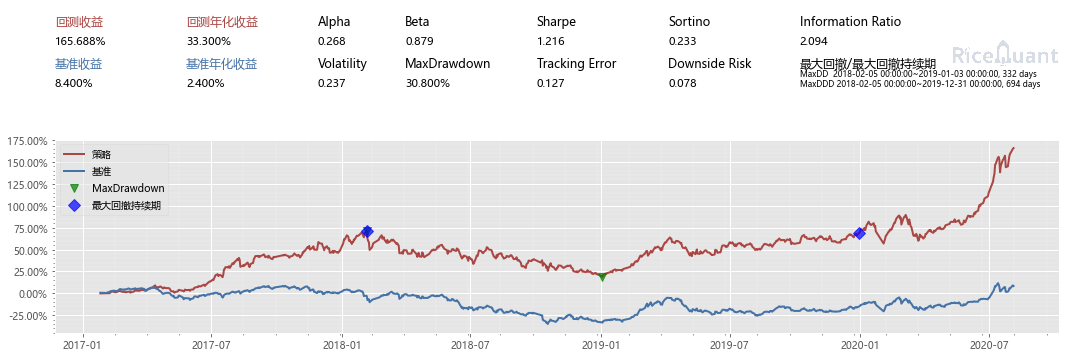

In [11]:
backtest_results = rqalpha_plus.run_func(init=init, handle_bar=handle_bar_500_enhanced, config=config)